# Forecasting bike usage in Berlin
1. EDA
2. Preparing and cleansing data
3. Forecast data

## Import packages and data

In [46]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [47]:
data = pd.read_csv("../data/data_all_years.csv", parse_dates=[0])

## EDA

In [48]:
data.head()

,DateTime,station,cyclists
0,2017-12-29 07:00:00,bers,32
1,2017-12-29 07:00:00,breo,18
2,2017-12-29 07:00:00,brew,14
3,2017-12-29 07:00:00,frao,14
4,2017-12-29 07:00:00,fraw,16


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1211307 entries, 0 to 1211306
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype         
---  ------    --------------    -----         
 0   DateTime  1211307 non-null  datetime64[ns]
 1   station   1211307 non-null  object        
 2   cyclists  1211307 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 27.7+ MB


In [50]:
data.describe(include='all', datetime_is_numeric=True)

,DateTime,station,cyclists
count,1211307,1211307,1.211307e+06
unique,NaN,26,NaN
top,NaN,schw,NaN
freq,NaN,77466,NaN
mean,2018-04-10 15:15:56.587554048,NaN,9.014837e+01
min,2012-03-01 00:00:00,NaN,-1.000000e+00
25%,2017-01-05 22:00:00,NaN,1.100000e+01
50%,2018-05-06 05:00:00,NaN,4.600000e+01
75%,2019-09-03 13:00:00,NaN,1.270000e+02
max,2020-12-31 23:00:00,NaN,2.167000e+03


<AxesSubplot:xlabel='cyclists', ylabel='Count'>

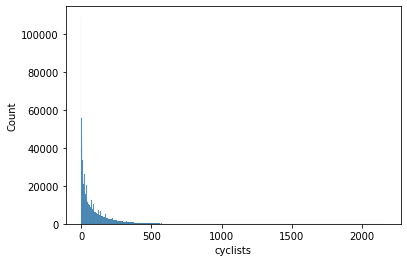

In [51]:
sns.histplot(data=data, x='cyclists' )

### Missing values

In [52]:
data.isna().sum()


DateTime    0
station     0
cyclists    0
dtype: int64

### Errors

<AxesSubplot:xlabel='count', ylabel='station'>

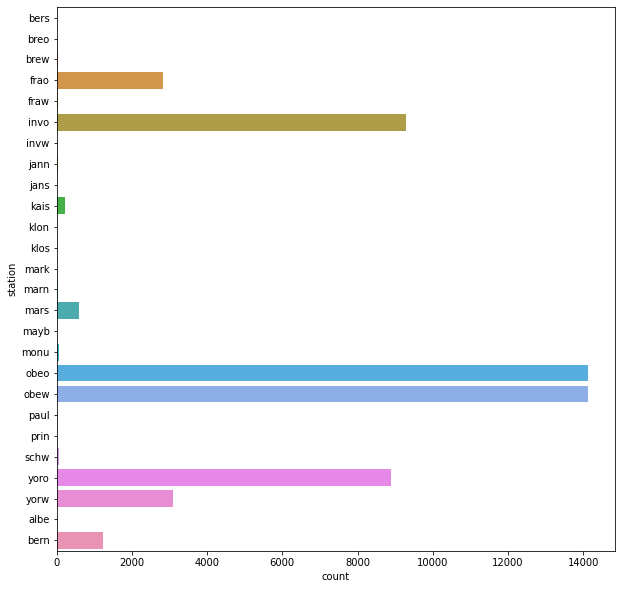

In [53]:
# counting values for each station
amount_of_measurements = pd.DataFrame(columns=['station', 'count'])
for i in data['station'].unique():
    amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[(data['station'] == i) & (data['cyclists'] == -1)].shape[0]}, ignore_index=True)

plt.figure(figsize=(10, 10))
sns.barplot(data=amount_of_measurements, x='count', y='station')

### Outliers

<AxesSubplot:ylabel='cyclists'>

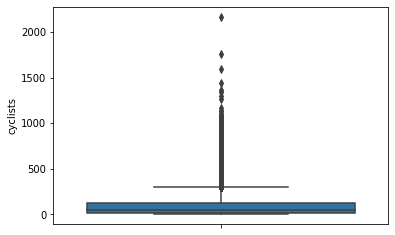

In [54]:
sns.boxplot(data=data, y='cyclists')

<AxesSubplot:xlabel='count', ylabel='station'>

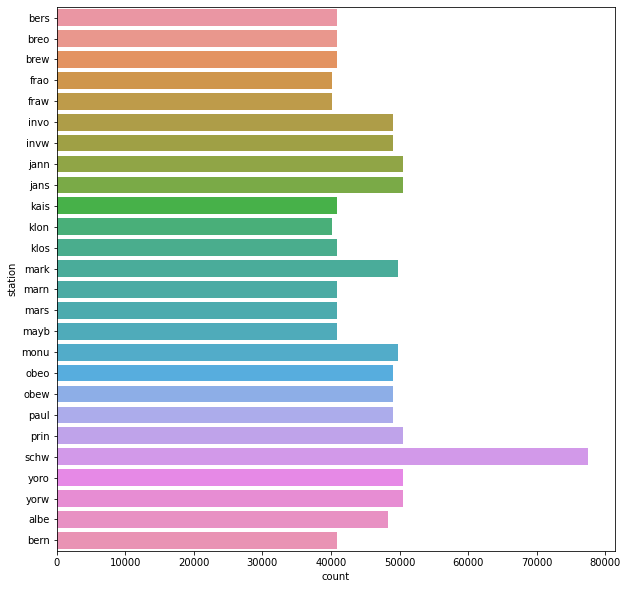

In [55]:
# counting values for each station
amount_of_measurements = pd.DataFrame(columns=['station', 'count'])
for i in data['station'].unique():
    amount_of_measurements = amount_of_measurements.append({'station':i, 'count':data[data['station'] == i].shape[0]}, ignore_index=True)

plt.figure(figsize=(10, 10))
sns.barplot(data=amount_of_measurements, x='count', y='station')

## Cleaning data

In [60]:
data_clean = data
data_clean.loc[data.cyclists == -1, 'cyclists'] = np.nan
data_clean.dropna(inplace=True)
data_clean.shape[0]

1156547

## Adding more information
I augment the records by calculated information  
- weekend?
- school holiday?
- bank holiday?
- winter or summer?

In [64]:
data_augmented = data_clean
weekend_list = []
for row_weekday in data_augmented['DateTime']:
    if row_weekday.weekday() >= 6:
        weekend_list.append(1)
    else:
        weekend_list.append(0)
data_augmented['weekend'] = weekend_list

In [75]:
summer_list = [1 if date.month >= 3 and date.month <= 10 else 0 for date in data_augmented['DateTime']]
data_augmented['summer'] = summer_list

In [76]:
data_augmented.head()

,DateTime,station,cyclists,weekend,summer
0,2017-12-29 07:00:00,bers,32.0,0,0
1,2017-12-29 07:00:00,breo,18.0,0,0
2,2017-12-29 07:00:00,brew,14.0,0,0
3,2017-12-29 07:00:00,frao,14.0,0,0
4,2017-12-29 07:00:00,fraw,16.0,0,0
